# EV Charging – Forecasting UK private BEV registrations from DfT VEH9901

This notebook uses the Department for Transport VEH9901 (October 2025) dataset to build a
simple time-based forecasting model for UK private battery-electric car registrations.

The aim is to:

- Aggregate BEV cars to UK totals by year of first registration
- Train a simple regression model on 2012–2020 and test on 2021–2024  
- Use the best model (degree-2 polynomial regression) to forecast 2025–2030  
- Compare this with an alternative model (Random Forest) and discuss why it performs poorly

## 1. Setup and load VEH9901 data

Import core libraries and load the raw VEH9901 extract from the project data folder.
Do a quick inspection to understand the structure and data types.


In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

df = pd.read_csv("../Data/raw_data/veh9901 - October 2025 - raw.csv")

df.head()

,ONS_Code,Region,Upper Layer Local Authority (ULA),Lower Layer Local Authority (LLA),Units,BodyType,Fuel,VED_Band,Keepership,YearFirstReg,Number
0,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2012,1
1,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2016,1
2,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2017,1
3,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2018,2
4,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2019,3


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510514 entries, 0 to 510513
Data columns (total 11 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ONS_Code                           510514 non-null  object
 1   Region                             510514 non-null  object
 2   Upper Layer Local Authority (ULA)  510514 non-null  object
 3   Lower Layer Local Authority (LLA)  510514 non-null  object
 4   Units                              510514 non-null  object
 5   BodyType                           510514 non-null  object
 6   Fuel                               510514 non-null  object
 7   VED_Band                           510514 non-null  object
 8   Keepership                         510514 non-null  object
 9   YearFirstReg                       510514 non-null  int64 
 10  Number                             510514 non-null  object
dtypes: int64(1), object(10)
memory usage: 42.8+ MB


## 2. Filter to private BEV cars and clean numeric columns

Focus the dataset on battery-electric cars only.

Convert Number to a numeric type so that aggregations and models behave correctly.

In [3]:
df["Number"] = pd.to_numeric(df["Number"], errors="coerce")
df["Number"] = df["Number"].fillna(0).astype(int)

bev = df[
    (df["Fuel"] == "BATTERY ELECTRIC") &
    (df["BodyType"] == "Cars") &
    (df["Units"] == "Number")
]

bev.head()

,ONS_Code,Region,Upper Layer Local Authority (ULA),Lower Layer Local Authority (LLA),Units,BodyType,Fuel,VED_Band,Keepership,YearFirstReg,Number
0,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2012,1
1,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2016,1
2,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2017,1
3,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2018,2
4,E06000001,North East,Hartlepool,[z],Number,Cars,BATTERY ELECTRIC,A: 0,Company,2019,3


## 3. Aggregate to UK-level registrations and choose the modelling period

Aggregate the cleaned data to UK totals by year of first registration, summing across
all local authorities.

Focus on the modern BEV era (2012–2024) and drop 2025, because the October snapshot does
not represent a full year of registrations.


In [4]:
bev_uk = (
    bev.groupby("YearFirstReg", as_index=False)["Number"]
       .sum()
       .sort_values("YearFirstReg")
)

bev_uk

,YearFirstReg,Number
0,2002,173
1,2003,1
2,2004,5
3,2005,14
4,2006,32
5,2007,79
6,2008,25
7,2009,28
8,2010,49
9,2011,535


In [5]:
bev_uk_mod = bev_uk[
    (bev_uk["YearFirstReg"] >= 2012) &
    (bev_uk["YearFirstReg"] <= 2024)
].copy()

bev_uk_mod

,YearFirstReg,Number
10,2012,835
11,2013,1684
12,2014,4922
13,2015,7454
14,2016,8311
15,2017,11515
16,2018,13307
17,2019,33675
18,2020,91497
19,2021,131399


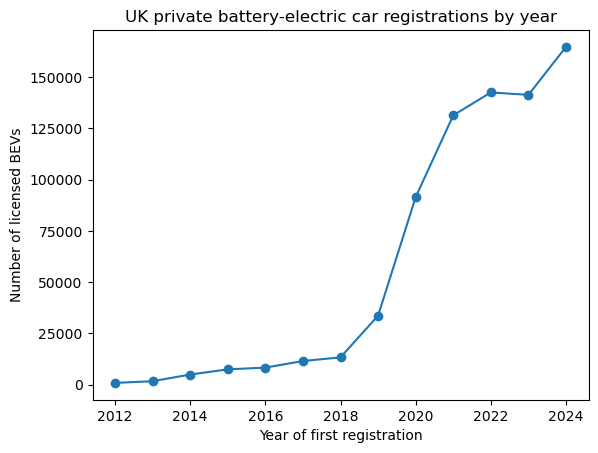

In [6]:
plt.plot(bev_uk_mod["YearFirstReg"], bev_uk_mod["Number"], marker="o")
plt.xlabel("Year of first registration")
plt.ylabel("Number of licensed BEVs")
plt.title("UK private battery-electric car registrations by year")
plt.show()

## 4. Train–test split (2012–2020 vs 2021–2024)


In [7]:
cutoff = 2020
train = bev_uk_mod[bev_uk_mod["YearFirstReg"] <= cutoff]
test  = bev_uk_mod[bev_uk_mod["YearFirstReg"] > cutoff]

X_train = train[["YearFirstReg"]].values
y_train = train["Number"].values

X_test  = test[["YearFirstReg"]].values
y_test  = test["Number"].values

train, test

(    YearFirstReg  Number
 10          2012     835
 11          2013    1684
 12          2014    4922
 13          2015    7454
 14          2016    8311
 15          2017   11515
 16          2018   13307
 17          2019   33675
 18          2020   91497,
     YearFirstReg  Number
 19          2021  131399
 20          2022  142557
 21          2023  141394
 22          2024  164773)

## 5. Baseline model – quadratic (degree-2) polynomial regression

Fit a degree-2 polynomial regression using year as the only predictor.  
Evaluate performance on the 2021–2024 hold-out years using MAE and RMSE, and
plot actual vs predicted values.


In [8]:
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred_test = model.predict(X_test_poly)

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = mse ** 0.5
print("Test MAE:", mae)
print("Test RMSE:", rmse)


Test MAE: 30866.354761600494
Test RMSE: 35501.88902508495


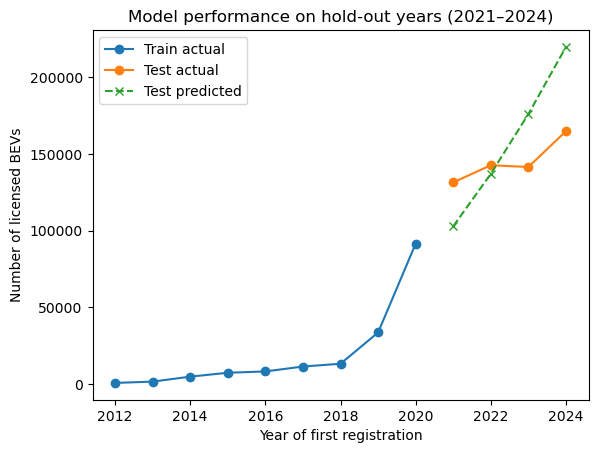

In [9]:
plt.plot(train["YearFirstReg"], y_train, marker="o", label="Train actual")
plt.plot(test["YearFirstReg"], y_test, marker="o", label="Test actual")
plt.plot(test["YearFirstReg"], y_pred_test, marker="x", linestyle="--", label="Test predicted")

plt.xlabel("Year of first registration")
plt.ylabel("Number of licensed BEVs")
plt.title("Model performance on hold-out years (2021–2024)")
plt.legend()
plt.show()


## 6. Forecast 2025–2030 with the selected model

Use the fitted quadratic model to forecast BEV registrations for
2025–2030 and plot the combined historical + forecast series.

In [10]:
future_years = np.arange(2025, 2031)

X_future = future_years.reshape(-1, 1)
X_future_poly = poly.transform(X_future)
y_future_pred = model.predict(X_future_poly)

forecast = pd.DataFrame({
    "YearFirstReg": future_years,
    "Predicted_BEVs": y_future_pred.round().astype(int)
})

forecast


,YearFirstReg,Predicted_BEVs
0,2025,268008
1,2026,321202
2,2027,379154
3,2028,441864
4,2029,509332
5,2030,581559


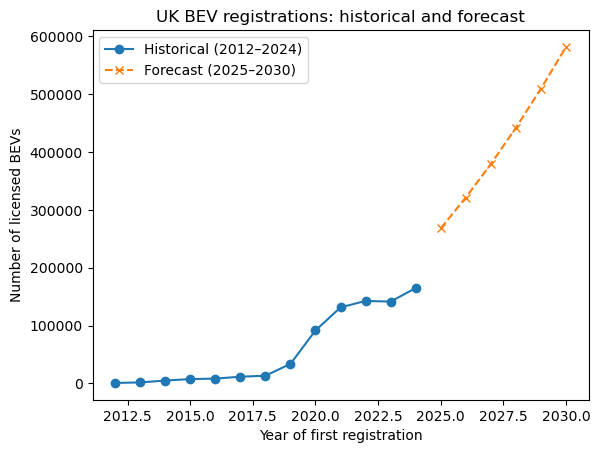

In [11]:
plt.plot(bev_uk_mod["YearFirstReg"], bev_uk_mod["Number"],
         marker="o", label="Historical (2012–2024)")

plt.plot(forecast["YearFirstReg"], forecast["Predicted_BEVs"],
         marker="x", linestyle="--", label="Forecast (2025–2030)")

plt.xlabel("Year of first registration")
plt.ylabel("Number of licensed BEVs")
plt.title("UK BEV registrations: historical and forecast")
plt.legend()
plt.show()


## 7. Model comparison – polynomial degrees and Random Forest

Compare polynomial regression models with degrees 1–4 and a RandomForestRegressor
to understand the trade-offs and why the quadratic model is chosen for forecasting.

In [12]:
results = []

for deg in [1, 2, 3, 4]:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly  = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred_test = model.predict(X_test_poly)
    
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = mse ** 0.5

    results.append({
        "degree": deg,
        "MAE": mae,
        "RMSE": rmse
    })

pd.DataFrame(results)


,degree,MAE,RMSE
0,1,73845.672222,74054.306479
1,2,30866.354762,35501.889025
2,3,182151.694824,225142.542472
3,4,182531.372070,225640.940230


In [13]:
best_deg = 2

In [14]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=4,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_test_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_rf = mean_squared_error(y_test, y_pred_test_rf) ** 0.5

mae_rf, rmse_rf


(74256.16, 75250.97279193871)

In [15]:
comparison = pd.DataFrame([
    {
        "Model": f"Polynomial (deg={r['degree']})",
        "MAE": r["MAE"],
        "RMSE": r["RMSE"]
    } for r in results
] + [
    {
        "Model": "Random Forest",
        "MAE": mae_rf,
        "RMSE": rmse_rf
    }
])

comparison


,Model,MAE,RMSE
0,Polynomial (deg=1),73845.672222,74054.306479
1,Polynomial (deg=2),30866.354762,35501.889025
2,Polynomial (deg=3),182151.694824,225142.542472
3,Polynomial (deg=4),182531.372070,225640.940230
4,Random Forest,74256.160000,75250.972792


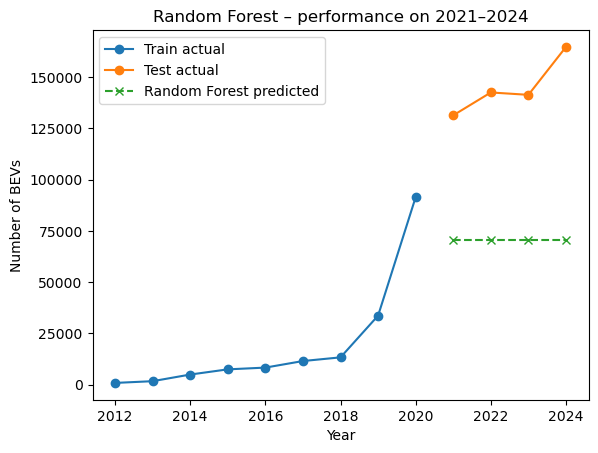

In [16]:
plt.plot(train["YearFirstReg"], y_train, marker="o", label="Train actual")
plt.plot(test["YearFirstReg"], y_test, marker="o", label="Test actual")
plt.plot(test["YearFirstReg"], y_pred_test_rf, marker="x", linestyle="--",
         label="Random Forest predicted")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of BEVs")
plt.title("Random Forest – performance on 2021–2024")
plt.show()


## 8. Summary and limitations

- A degree-2 polynomial regression model provides the best balance of simplicity,
  interpretability and test performance on 2021–2024.
- The model slightly over-predicts the latest years where BEV adoption accelerates
  most strongly, so forecasts for 2025–2030 should be treated as indicative rather
  than exact counts.
- The RandomForestRegressor fits the training data well but produces almost flat
  predictions for the test years, illustrating that tree models are poor at
  extrapolating trends beyond the range of the training period.
- In the wider EV charging project, these UK-level BEV forecasts are used
  as context when interpreting charger rollout and plugs-per-BEV KPIs, rather
  than as a definitive prediction of future EV demand.
